### Imports

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
from difflib import SequenceMatcher

### Processing 

In [2]:
df_1=pd.read_excel("../raw_data/as_1_4_results.xlsx")
df_2=pd.read_excel("../raw_data/as_5_9_results.xlsx")
df_3=pd.read_excel("../raw_data/as_10_results.xlsx")
predicted_grades=pd.read_csv("../raw_data/as_predicted_results.csv")

/Users/andrewsmith/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
predicted_grades["Candidate name"]=predicted_grades["Candidate name"].apply(lambda x:x.replace(" ","").replace(":",""))

In [4]:
def processing_function(df):
    column_names = ['Syllabus',
     'Option code',
     'Centre number',
     'Class',
     'English Name',
     'Candidate name',
     'Component 12 raw mark',
     'Component 12 adjusted mark',
     'Component 12 grade',
     'Component 22 raw mark',
     'Component 22 adjusted mark',
     'Component 22 grade',
     'Component 12 final mark',
     'Component 22 final mark',
     'Syllabus total mark',
     'Syllabus grade']
    df.columns=column_names
    df = df.drop(index=[list(df.index)[i] for i in [0,1,-2,-1]])
    df = df.reset_index(drop=True)
    df.drop(index=[0])
    df=df.dropna()
    df["Syllabus grade"] = df["Syllabus grade"].apply(lambda x:x.upper())
    df["Candidate name"] = df["Candidate name"].apply(lambda x:x.replace(":","").replace(" ","").upper())
    return df

### Processed df

In [5]:
df = pd.concat([processing_function(df_1).drop(index=[0]),processing_function(df_2).drop(index=[0]),processing_function(df_3).drop(index=[0])]).sort_values(by="Syllabus grade",ignore_index=True)

### Merging dfs

In [6]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [7]:
def closest_match_finder(name,predicted_grades):
    match_dict = dict()
    for element in list(predicted_grades["Candidate name"]):
        match_dict[element]=similar(name,element)
    key_list = list(match_dict.keys())
    value_list = list(match_dict.values())
    max_score = max(value_list)
    name_predicted_grades = key_list[value_list.index(max_score)]
    return (name_predicted_grades,name,max_score)
        

In [8]:
merged_df = df.merge(predicted_grades,on="Candidate name",how="left")

In [9]:
incorrect_names = list(merged_df[merged_df["Predicted grade"].isna()]["Candidate name"])

In [10]:
correction_list = [closest_match_finder(element,predicted_grades) for element in incorrect_names]

In [11]:
for element in correction_list: 
    if element[2]<0.8: 
        correction_list.remove(element)

In [12]:
predicted_grades.set_index("Candidate name",drop=False,inplace=True)
for element in correction_list:
    predicted_grades.loc[element[0],"Candidate name"]=element[1]
    
    

In [13]:
predicted_grades.reset_index(drop=True,inplace=True)

In [14]:
merged_df = df.merge(predicted_grades,on="Candidate name",how="left").dropna()


### Grade Graphing

In [29]:
def prop_bar_overall_percentages(df): 
    x,y = 'Class', 'Syllabus grade'
    df = df.groupby(x)[y].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('Percent').reset_index()
    sns.set()
    g = sns.catplot(y="Syllabus grade", 
                    x="Percent",
                    hue="Class",
                    kind='bar',
                    data=df,
                    order=["U","E","D","C","B","A"][::-1], 
                    hue_order=["AS10","AS9","AS6","AS5","AS4","AS3","AS2","AS1"][::-1],
                    orient="h",
                    height=10,
                    aspect=1.5,
                    edgecolor="white"
                   )
    g.ax.set_xlim(0,100)
    plt.xticks(np.arange(0,101,10),fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Percent",fontsize=15)
    plt.ylabel("")
    plt.title("AS Economics Results August 2021",fontsize=20,pad=10)

In [ ]:
def prop_bar_grade_percentages(df): 
    y,x = 'Class', 'Syllabus grade'
    df = df.groupby(x)[y].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('Percent').reset_index()
    sns.set()
    g = sns.catplot(y="Syllabus grade", 
                    x="Percent",
                    hue="Class",
                    kind='bar',
                    data=df,
                    order=["U","E","D","C","B","A"][::-1], 
                    hue_order=["AS10","AS9","AS6","AS5","AS4","AS3","AS2","AS1"][::-1],
                    orient="h",
                    height=10,
                    aspect=1.5,
                    edgecolor="white"
                    )
    g.ax.set_xlim(0,100)
    plt.xticks(np.arange(0,101,10),fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("")
    plt.ylabel("")
    plt.title("AS Economics Results August 2021",fontsize=20,pad=10)

In [ ]:
def waffle_plots_grade_distribution(df):
    possible_grade_list = ["U","E","D","C","B","A"][::-1]
    class_list = ["AS10","AS9","AS6","AS5","AS4","AS3","AS2","AS1"][::-1]
    y,x = 'Class', 'Syllabus grade'
    df = df.groupby(x)[y].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('Percent').reset_index().sort_values(by=["Class","Syllabus grade"])
    main_dictionary = dict()
    
    for group in class_list:
        grade_list = list(df[df["Class"]==group]["Syllabus grade"])
        percentage_list = list(df[df["Class"]==group]["Percent"])
        grade_dict = dict(zip(grade_list,percentage_list))
        for grade in possible_grade_list: 
            if grade not in grade_dict.keys():
                grade_dict[grade]=0 
        main_dictionary[group]=grade_dict
    main_df=pd.DataFrame()
   
    for group in class_list:
        results = list(main_dictionary[group].values())
        grades = list(main_dictionary[group].keys())
        class_df = pd.DataFrame({"Grades":grades,group:results},
                                index=[0,1,2,3,4,5]).sort_values(by="Grades").set_index("Grades")
        main_df = pd.concat([main_df,class_df],axis=1)
    main_df = main_df.transpose()
    for i in possible_grade_list:
        data=dict(main_df[i])
        plt.figure(FigureClass=Waffle,
        labels=[f"{k} ({int(v)}%)" for k, v in data.items()],
        rows=10,
        columns=10,
        values=data,
        legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
        #icons='user-graduate',
        block_arranging_style='new-line',
        #vertical=True
        )
        plt.title(f"{i} grades by class")
        plt.savefig(f"../graphs/{i} grade distribution waffle")

        
        

In [ ]:
def waffle_plots_individual_class(df):
    
    possible_grade_list = list(df["Syllabus grade"].unique())
    class_list = ["AS10","AS9","AS6","AS5","AS4","AS3","AS2","AS1"][::-1]
    y,x = 'Class', 'Syllabus grade'
    df = df.groupby(x)[y].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('Percent').reset_index().sort_values(by=["Class","Syllabus grade"])
    main_dictionary = dict()
    
    for group in class_list:
        grade_list = list(df[df["Class"]==group]["Syllabus grade"])
        percentage_list = list(df[df["Class"]==group]["Percent"])
        grade_dict = dict(zip(grade_list,percentage_list))
        for grade in possible_grade_list: 
            if grade not in grade_dict.keys():
                grade_dict[grade]=0 
        main_dictionary[group]=grade_dict
    main_df=pd.DataFrame()
   
    for group in class_list:
        results = list(main_dictionary[group].values())
        grades = list(main_dictionary[group].keys())
        class_df = pd.DataFrame({"Grades":grades,group:results},
                                index=[0,1,2,3,4,5]).sort_values(by="Grades").set_index("Grades")
        main_df = pd.concat([main_df,class_df],axis=1)
    

    plots=dict()
    for i in range(len(class_list)):
        plots[821+i]={
            'values': main_df[class_list[i]],
            'labels': [f"{k} ({int(v)}%)" for k, v in main_df[class_list[i]].items()],
            'legend': {
                'loc': 'upper left',
                'bbox_to_anchor': (1.05, 1),
                'fontsize': 12.5
            },
            'title': {
                'label': f'{class_list[i]} results',
                'loc': 'center',
                'fontdict':{
                    'fontsize':15
                }
            }
        }
    
    fig=plt.figure(FigureClass=Waffle,plots=plots,rows=10,columns=10, figsize=(25,50))
    plt.show()
    

In [ ]:
def waffle_plots_single_class(df):
    
    possible_grade_list = ["U","E","D","C","B","A"][::-1]
    class_list = ["AS10","AS9","AS6","AS5","AS4","AS3","AS2","AS1"][::-1]
    x,y = 'Class', 'Syllabus grade'
    df = df.groupby(x)[y].value_counts(normalize=True)
    df = df.mul(100)
    df = df.rename('Percent').reset_index().sort_values(by=["Class","Syllabus grade"])
    main_dictionary = dict()
    
    for group in class_list:
        grade_list = list(df[df["Class"]==group]["Syllabus grade"])
        percentage_list = list(df[df["Class"]==group]["Percent"])
        grade_dict = dict(zip(grade_list,percentage_list))
        for grade in possible_grade_list: 
            if grade not in grade_dict.keys():
                grade_dict[grade]=0 
        main_dictionary[group]=grade_dict
    main_df=pd.DataFrame()
   
    for group in class_list:
        results = list(main_dictionary[group].values())
        grades = list(main_dictionary[group].keys())
        class_df = pd.DataFrame({"Grades":grades,group:results},
                                index=[0,1,2,3,4,5]).sort_values(by="Grades").set_index("Grades")
        main_df = pd.concat([main_df,class_df],axis=1)
    
    for i in class_list:
        data=dict(main_df[i])
        plt.figure(FigureClass=Waffle,
        labels=[f"{k} ({int(v)}%)" for k, v in data.items()],
        rows=10,
        columns=10,
        values=data,
        legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
        #icons='user-graduate',
        block_arranging_style='new-line',
        #vertical=True
        )
        plt.title(f"{i} grades by class")
        plt.savefig(f"../graphs/{i} waffle")

### Analyzing prediction accuracy

In [15]:
def accuracy_descriptor(accuracy_metric): 
    if accuracy_metric == 0: 
        return "Correct" 
    if accuracy_metric<0: 
        return "Over"
    if accuracy_metric>0:
        return "Under"

In [16]:
grade_list = list(merged_df["Syllabus grade"].unique())
grade_map = {k: v for k,v in zip(grade_list,list(range(1,len(grade_list)+1))[::-1])}
merged_df["Syllabus grade encoded"]=merged_df["Syllabus grade"].map(grade_map)
merged_df["Predicted grade encoded"]=merged_df["Predicted grade"].map(grade_map)
merged_df["Accuracy metric"] = merged_df["Syllabus grade encoded"]-merged_df["Predicted grade encoded"]
merged_df.drop_duplicates(subset=["Candidate name"],keep="first",inplace=True)
merged_df["Accuracy description"]=merged_df["Accuracy metric"].apply(lambda x:accuracy_descriptor(x))


### Data for Sankey diagram

In [ ]:
merged_df["Predicted grade"].value_counts()

In [ ]:
x,y = 'Predicted grade', 'Syllabus grade'
merged_df.groupby(x)[y].value_counts()



### Prediction graphing functions

In [19]:
def waffle_plots_summary_grade_predictions(merged_df): 
    x,y = 'Predicted grade', 'Accuracy description'
    merged_df_grouped = merged_df.groupby(x)[y].value_counts(normalize=True)
    merged_df_grouped = merged_df_grouped.mul(100)
    merged_df_grouped = merged_df_grouped.rename('Percent').reset_index().sort_values(by=["Predicted grade","Accuracy description"])
    
    possible_grade_list = ["A","B","C","D","E","U"]
    main_dictionary = dict()
    for grade in possible_grade_list:
        grade_list = list(merged_df_grouped[merged_df_grouped["Predicted grade"]==grade]["Accuracy description"])
        percentage_list = list(merged_df_grouped[merged_df_grouped["Predicted grade"]==grade]["Percent"])
        grade_dict = dict(zip(grade_list,percentage_list))
        for element in ["Correct","Over","Under"]: 
            if element not in grade_dict.keys():
                grade_dict[element]=0
        main_dictionary[grade]=grade_dict

    for i in possible_grade_list:
            data=main_dictionary[i]
            plt.figure(FigureClass=Waffle,
            labels=[f"{k} prediction ({int(v)}%)" for k, v in data.items()],
            rows=10,
            columns=10,
            values=data,
            legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
            #icons='user-graduate',
            block_arranging_style='new-line',
            #vertical=True
            )
            plt.title(f"{i} grade predictions accuracy")
            plt.savefig(f"../graphs/{i} prediction accuracy waffle")

In [ ]:
def waffle_plots_complete_grade_predictions(merged_df):
    y,x = 'Syllabus grade', 'Predicted grade'
    merged_df_grouped = merged_df.groupby(x)[y].value_counts(normalize=True)
    merged_df_grouped = merged_df_grouped.mul(100)
    merged_df_grouped = merged_df_grouped.rename('Percent').reset_index().sort_values(by=["Syllabus grade","Predicted grade"])
    possible_grade_list = ["A","B","C","D","E","U"]
    main_dictionary = dict()
    for grade in possible_grade_list:
        grade_list = list(merged_df_grouped[merged_df_grouped["Syllabus grade"]==grade]["Predicted grade"])
        percentage_list = list(merged_df_grouped[merged_df_grouped["Syllabus grade"]==grade]["Percent"])
        grade_dict = dict(zip(grade_list,percentage_list))
        for element in ["A","B","C","D","E","U"]: 
            if element not in grade_dict.keys():
                grade_dict[element]=0
        main_dictionary[grade]=grade_dict

    for i in possible_grade_list:
            data=main_dictionary[i]
            plt.figure(FigureClass=Waffle,
            labels=[f"{k} ({int(v)}%)" for k, v in data.items()],
            rows=10,
            columns=10,
            values=data,
            legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
            #icons='user-graduate',
            block_arranging_style='new-line',
            #vertical=True
            )
            plt.title(f"{i} grade predictions accuracy")

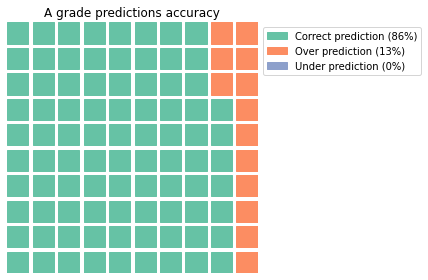

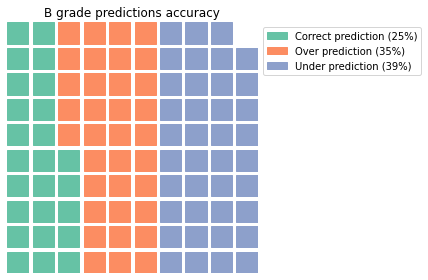

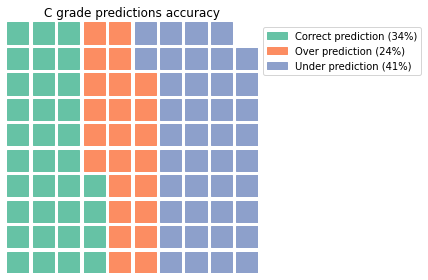

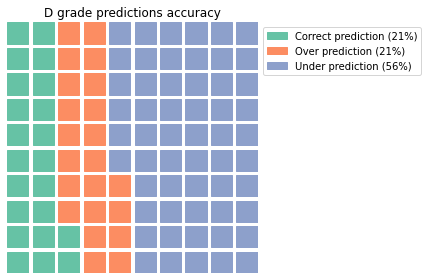

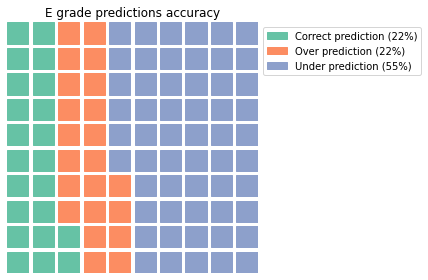

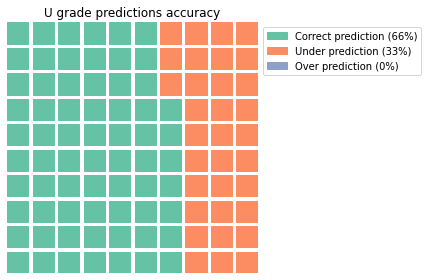

In [20]:
waffle_plots_summary_grade_predictions(merged_df)

In [ ]:
waffle_plots_complete_grade_predictions(merged_df)

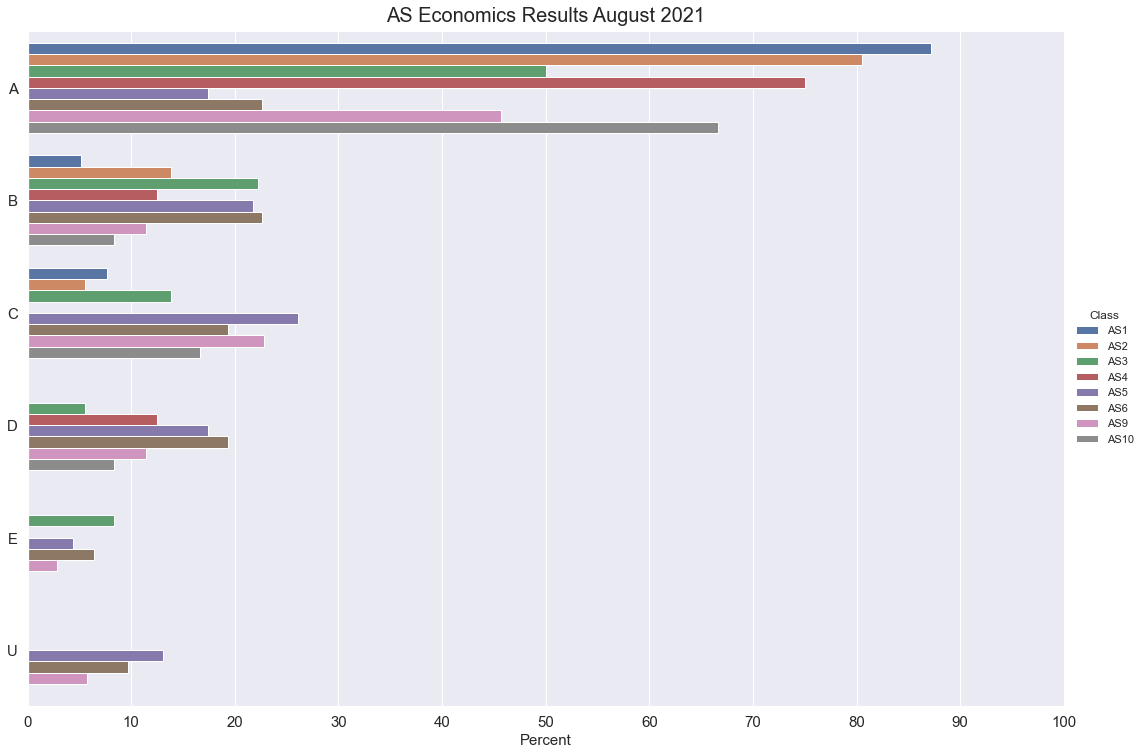

In [30]:
prop_bar_overall_percentages(df)